In [12]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

In [13]:
PATH = 'cats_and_dogs/cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, '')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [14]:
# 3

train_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=['test'], 
    shuffle=False,
    class_mode=None 
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


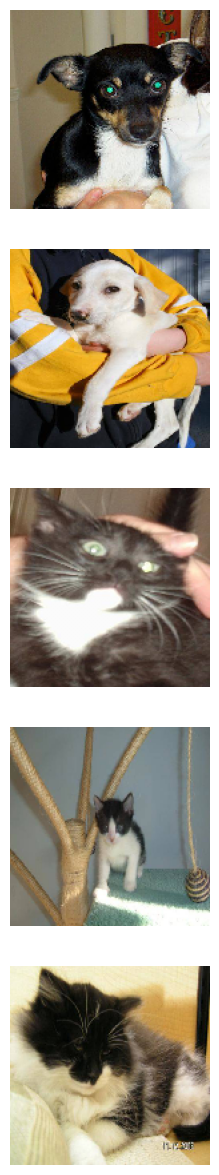

In [15]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages((sample_training_images[:5] + 1.0) / 2.0)


In [16]:
# 5
train_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2000 images belonging to 2 classes.


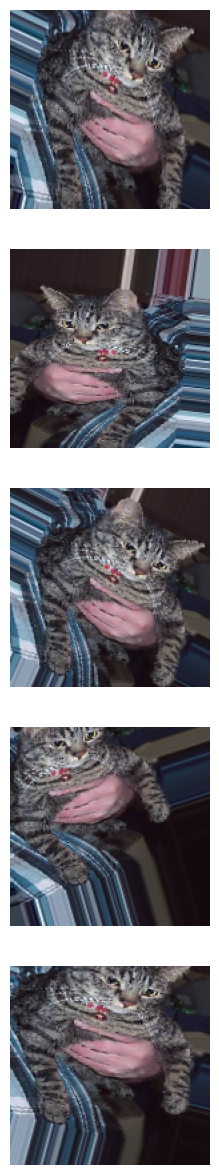

In [17]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [(train_data_gen[0][0][0] + 1.0) / 2.0 for i in range(5)]

plotImages(augmented_images)

In [18]:
# 7

# Carichiamo la base pre-addestrata
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# congeliamo i pesi esistenti per non distruggerli
base_model.trainable = False

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    base_model,
    GlobalAveragePooling2D(), # Trasforma le mappe di feature in un vettore
    Dropout(0.5),              # Regolarizzazione per evitare overfitting
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_20336\420538839.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# 8

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=6, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=0.00001,
    verbose=1
)

# Training
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs, 
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 699ms/step - accuracy: 0.5016 - loss: 1.1837 - val_accuracy: 0.8158 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.6641 - loss: 0.7970

d:\anaconda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.6641 - loss: 0.7970 - val_accuracy: 0.8583 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 640ms/step - accuracy: 0.7858 - loss: 0.4880 - val_accuracy: 0.9319 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8672 - loss: 0.4160 - val_accuracy: 0.9397 - val_loss: 0.1715 - learning_rate: 0.0010
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 662ms/step - accuracy: 0.8755 - loss: 0.3087 - val_accuracy: 0.9509 - val_loss: 0.1366 - learning_rate: 0.0010
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8672 - loss: 0.2553 - val_accuracy: 0.9509 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 634ms/step - accuracy: 0.8803 - loss: 0.2895 - val_accuracy: 0.9587 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8906 - loss: 0.2428 - val_accur

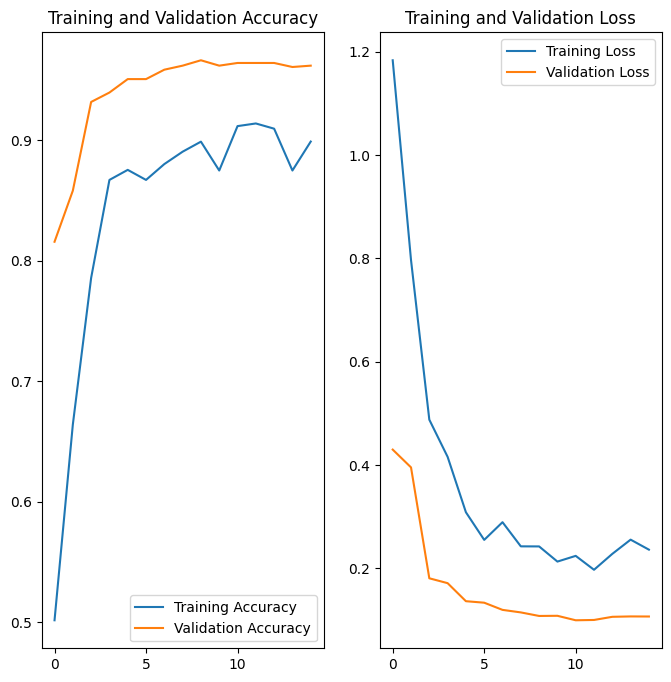

In [20]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
probabilities = model.predict(test_data_gen).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


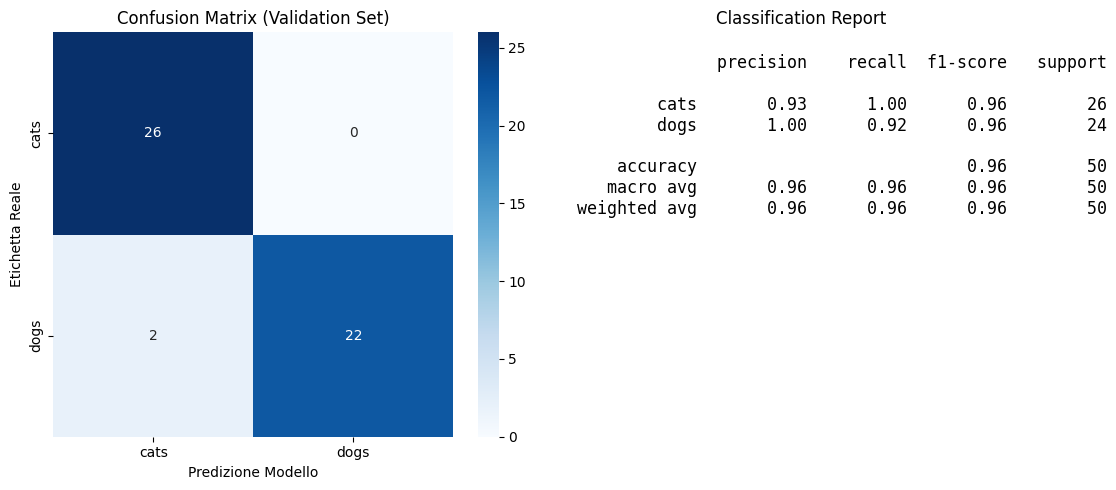

In [22]:
# Predizioni (valori tra 0 e 1)
y_pred_probs = probabilities
# Convertiamo in classi (0 o 1) usando lo split allo 0.5
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
# Etichette reali
y_true =   [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]
# Nomi delle classi
class_names = list(train_data_gen.class_indices.keys())
# 2. Creazione della Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Visualizzazione Grafica
plt.figure(figsize=(12, 5))

# Subplot 1: Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('Etichetta Reale')
plt.xlabel('Predizione Modello')

# Subplot 2: Report Testuale delle Metriche
plt.subplot(1, 2, 2)
plt.text(0.05, 0.5, classification_report(y_true, y_pred, target_names=class_names), 
         fontsize=12, family='monospace')
plt.axis('off')
plt.title('Classification Report')

plt.tight_layout()
plt.show()

Errori nel Test Set: 2 su 50
Accuratezza reale sul Test Set: 96.00%


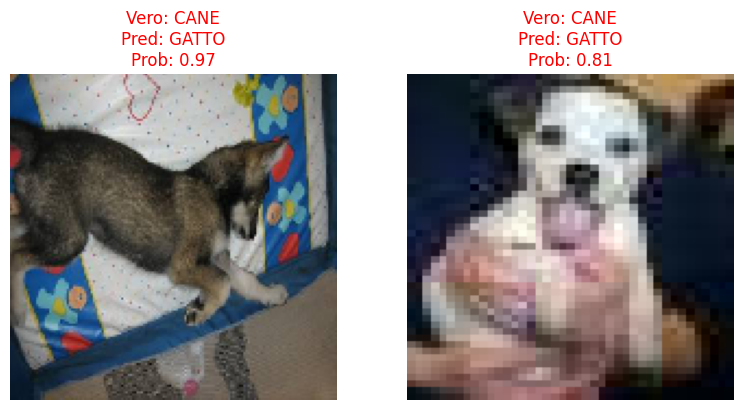

In [23]:


answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
           1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
           1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
           1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
           0, 0, 0, 0, 0, 0]

test_preds_binary = (probabilities > 0.5).astype(int)

# 1. Trova gli indici degli errori
test_errors = np.where(test_preds_binary != answers)[0]

print(f"Errori nel Test Set: {len(test_errors)} su {len(answers)}")
print(f"Accuratezza reale sul Test Set: {((len(answers)-len(test_errors))/len(answers))*100:.2f}%")

# 2. Recuperiamo le immagini dal generatore per visualizzarle
# Reset per essere sicuri dell'ordine
test_data_gen.reset()
test_images = next(test_data_gen) # Prende il primo batch di immagini del test

# 5. Visualizziamo gli errori
def plot_test_errors(error_indices, images, preds, actuals, probs):
    n_errors = len(error_indices)
    if n_errors == 0:
        print("Nessun errore trovato! Il modello ha fatto 50/50.")
        return
    
    cols = 5
    rows = (n_errors // cols) + 1
    plt.figure(figsize=(20, 4 * rows))
    
    for i, idx in enumerate(error_indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow((images[idx]+1)/2.0)
        
        actual_label = "CANE" if actuals[idx] == 1 else "GATTO"
        pred_label = "CANE" if preds[idx] == 1 else "GATTO"
        confidence = probs[idx] if preds[idx] == 1 else 1 - probs[idx]
        
        plt.title(f"Vero: {actual_label}\nPred: {pred_label}\nProb: {confidence:.2f}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_test_errors(test_errors, test_images, test_preds_binary, answers, probabilities)

In [24]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 96.0% of the images of cats and dogs.
You passed the challenge!
